In [1]:
import pyabf
import matplotlib.pyplot as plt
import numpy as np
from os import getcwd,listdir
from util import findStable_Bias, cal_points_qty, print_points_qty, plot_wave, plot_colormap, capture, write_target, plot_wave, check_close_fair_pair, map_ind_coor,plot_wave_with_index

# Start

參數記錄
格式：[abf_file,bins,Row,Col,volt,emf_bias,current_bias,start_ignore,end_ignore,start_extra,end_extra,start_single,end_single,first_row_repeat]
1. [24903000.abf,50,100,100,200,-300,0,2,12,5,0,True,False,6]
2. [24903001.abf,50,100,100,-200,-140,0,2,13,5,0,True,False,6]
3. [24o24001.abf,50,40,40,130,0,0,4,10,5,0,False,True.6]

In [2]:
abf_file = ["24o24001.abf"]

In [3]:
abf = [pyabf.ABF("abf\\"+x) for x in abf_file]
title_prefix = [x[:-4] for x in abf_file]
fig_save_path =getcwd()+"\\result\\"

In [4]:
bins = [50]
Row = [40]
Col = [40]

volt = [130]
emf_bias = [0]
current_bias = [0]

# start_ignore and end_ignore: extra points before reshape into rows
# start_extra and end_extra: extra points of each rows
start_ignore = [4] #Don't include the single point
end_ignore = [11]  #Don't include the single point
start_extra = [5]
end_extra = [0]
start_single = [False]
end_single = [False]
first_row_repeat = [6]
auto_fill = [True]

In [5]:
ignore = [(x,y) for x,y in zip(start_ignore,end_ignore)]
extra =  [(x,y) for x,y in zip(start_extra,end_extra)]
dim = [(x-1,y) for x,y in zip(Row,Col)]
single = [(x,y) for x,y in zip(start_single,end_single)]

In [6]:
for i in range(len(title_prefix)):
    total = (Row[i]-1)*(Col[i]+start_extra[i]+end_extra[i])+end_ignore[i]+start_ignore[i]+Col[i]*first_row_repeat[i]
    print(f"{abf_file[i]}'s total points should be {total}")

24o24001.abf's total points should be 2010


In [7]:
closes = []
fars = []
close_inds = []
far_inds = []
err_inds = []
for i in range(len(abf)):
    close,far,close_index,far_index,err_index = findStable_Bias(abf[i],volt[i],single=single[i],auto_fill = auto_fill[i])
    closes.append(close)
    fars.append(far)
    close_inds.append(close_index)
    far_inds.append(far_index)
    err_inds.append(err_index)

Now:79811.00,Mean: 1985.33, Std:5.34,Limits:[0.00,3970.65]
Error point index:1594, Error value: 79811
Close point found: 2010
Far point found: 2010


24o24001.abf has missing close/far point(s).
Error point index:1594
Index 1594 is located at Row = 28, among end extra points.


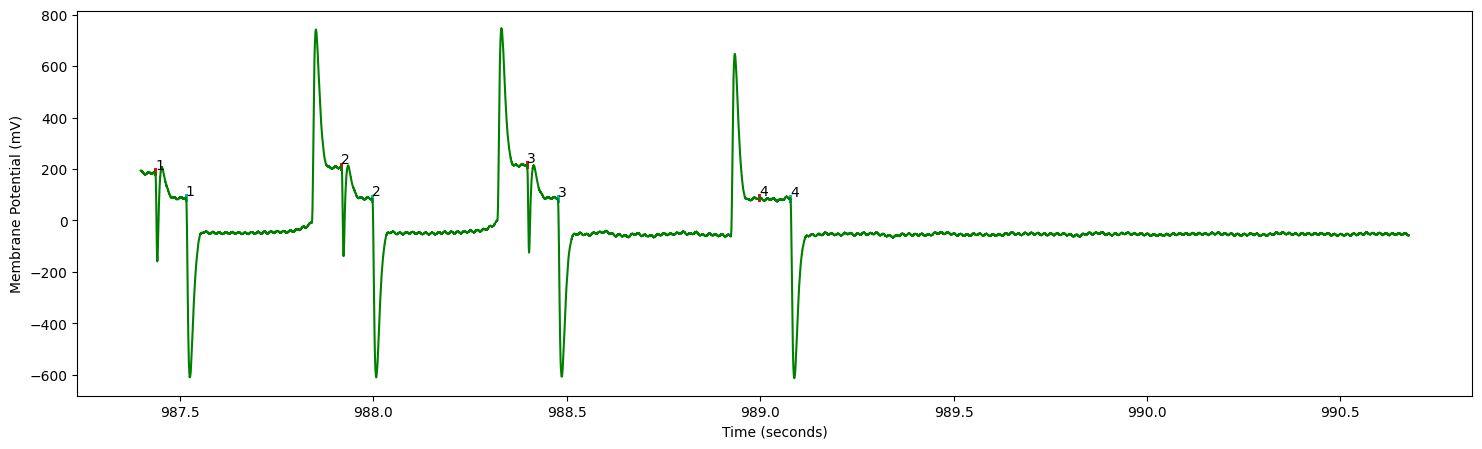

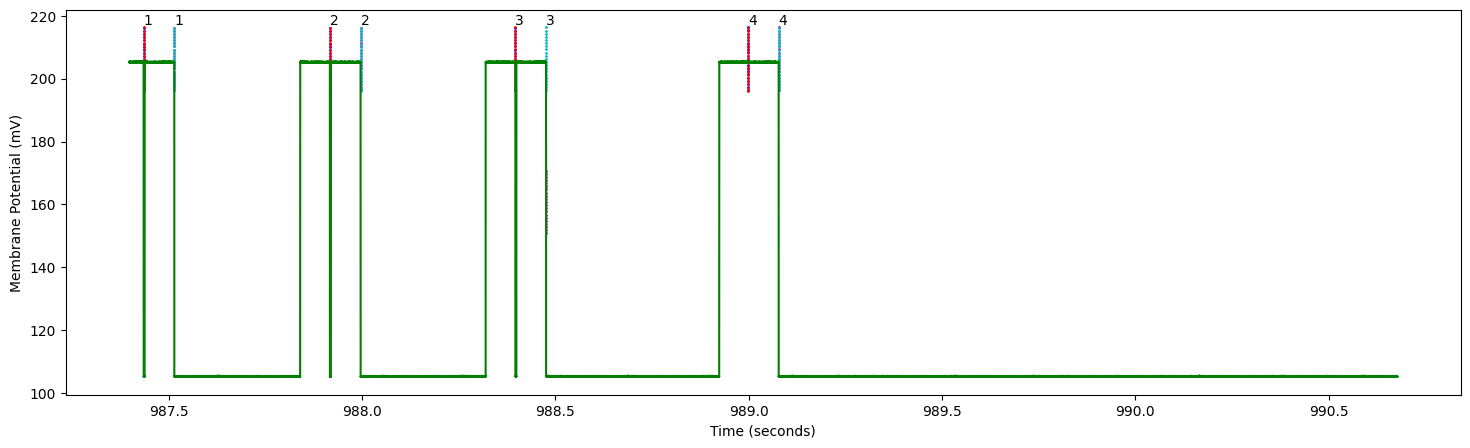

In [8]:
# Show missing close-far pairs
for i in range(len(abf)):
    if len(err_inds[i]) == 0:
        print(f"{abf_file[i]} does not have any missing close/far point.")
    else:
        print(f"{abf_file[i]} has missing close/far point(s).")
        for err in err_inds[i]:
            print(f"Error point index:{err}")
            map_ind_coor(err, Row[i], Col[i], ignore[i], extra[i], first_row_repeat[i])
            timeStart = close_inds[i][err]-40000
            timeEnd = far_inds[i][err]+40000
            plot_wave_with_index(abf[i],close_inds[i],far_inds[i],timeStart = timeStart, timeEnd = timeEnd,channel=2)
            plot_wave_with_index(abf[i],close_inds[i],far_inds[i],timeStart = timeStart, timeEnd = timeEnd,channel=4)

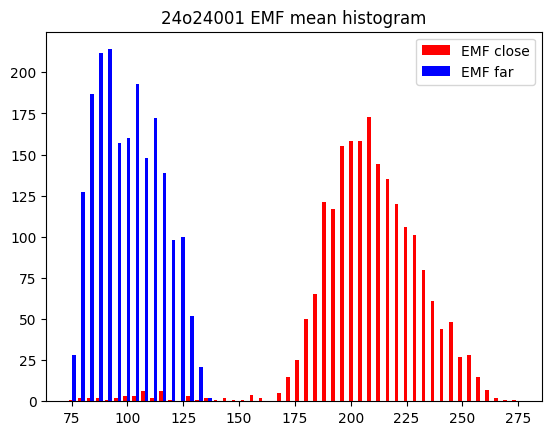

In [9]:
for i in range(len(abf_file)):
    plt.figure()
    plt.hist((closes[i],fars[i]),bins=bins[i],label = ('EMF close','EMF far'),color = ('red','blue'))
    plt.legend()
    plt.title("%s EMF mean histogram"%(title_prefix[i]))
    plt.savefig(fig_save_path+"%s EMF mean histogram"%(title_prefix[i]))
    plt.show()

2.142772 ± 0.198468


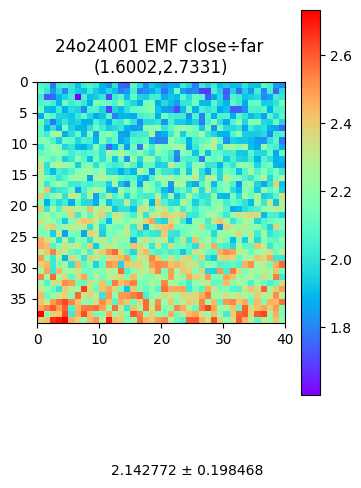

In [10]:
emf_divs = []
vmins = []
vmaxs = []
for i in range(len(abf_file)):
    target = closes[i]/fars[i]
    target = capture(target, first_row_repeat[i], ignore[i], extra[i], dim[i])
    mean = np.mean(target)
    std = np.std(target)
    print(f"%lf ± %lf" %(mean,std))
    emf_divs.append(target)
    vmins.append(target.min())
    vmaxs.append(target.max())
    
vmin = max(vmins)
vmax = min(vmaxs)
for i in range(len(abf_file)):
    figsize = (int(emf_divs[i].shape[0]/8), int(emf_divs[i].shape[1]/8))
    title = title_prefix[i] + " EMF close÷far"
    plot_colormap(emf_divs[i],title = title,path = fig_save_path, figsize = figsize,
                  vmin = vmin, vmax = vmax)

109.445152 ± 11.595330


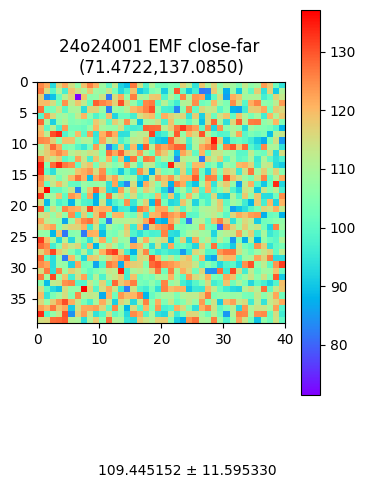

In [11]:
emf_difs = []
vmins = []
vmaxs = []
for i in range(len(abf_file)):
    target = closes[i]-fars[i]
    target = capture(target, first_row_repeat[i], ignore[i], extra[i], dim[i])
    mean = np.mean(target)
    std = np.std(target)
    print(f"%lf ± %lf" %(mean,std))
    emf_difs.append(target)
    vmins.append(target.min())
    vmaxs.append(target.max())
    
vmin = max(vmins)
vmax = min(vmaxs)
for i in range(len(abf_file)):
    figsize = (int(emf_difs[i].shape[0]/8), int(emf_difs[i].shape[1]/8))
    title = title_prefix[i] + " EMF close-far"
    plot_colormap(emf_difs[i],title = title,path = fig_save_path, figsize = figsize,
                  vmin = vmin, vmax = vmax)

In [12]:
# Calculate on Current
I_closes = []
I_fars = []
I_close_inds = []
I_far_inds = []
for i in range(len(abf)):
    close,far,close_index,far_index,err_index = findStable_Bias(abf[i],volt[i],single=single[i], channel = 0,auto_fill = auto_fill[i])
    I_closes.append(close)
    I_fars.append(far)
    I_close_inds.append(close_index)
    I_far_inds.append(far_index)

Now:79811.00,Mean: 1985.33, Std:5.34,Limits:[0.00,3970.65]
Error point index:1594, Error value: 79811
Close point found: 2010
Far point found: 2010


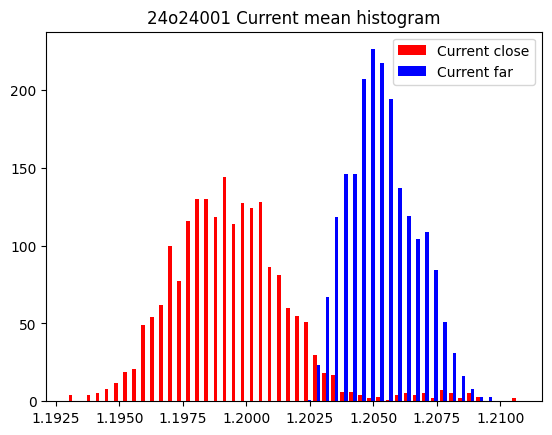

In [13]:
for i in range(len(abf_file)):
    plt.figure()
    plt.hist((I_closes[i],I_fars[i]),bins=bins[i],label = ('Current close','Current far'),color = ('red','blue'))
    plt.legend()
    plt.title("%s Current mean histogram"%(title_prefix[i]))
    plt.savefig(fig_save_path+"%s Current mean histogram"%(title_prefix[i]))
    plt.show()

0.995129 ± 0.001043


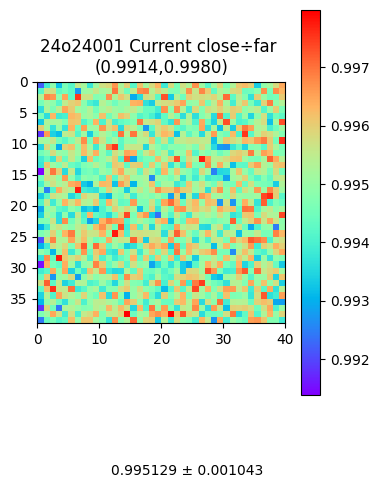

In [14]:
cur_divs = []
vmins = []
vmaxs = []
for i in range(len(abf_file)):
    target = I_closes[i]/I_fars[i]
    target = capture(target, first_row_repeat[i], ignore[i], extra[i], dim[i])
    mean = np.mean(target)
    std = np.std(target)
    print(f"%lf ± %lf" %(mean,std))
    cur_divs.append(target)
    vmins.append(target.min())
    vmaxs.append(target.max())
    
vmin = max(vmins)
vmax = min(vmaxs)
for i in range(len(abf_file)):
    figsize = (int(cur_divs[i].shape[0]/8), int(cur_divs[i].shape[1]/8))
    title = title_prefix[i] + " Current close÷far"
    plot_colormap(cur_divs[i],title = title,path = fig_save_path, figsize = figsize,
                  vmin = vmin, vmax = vmax)

-0.005871 ± 0.001258


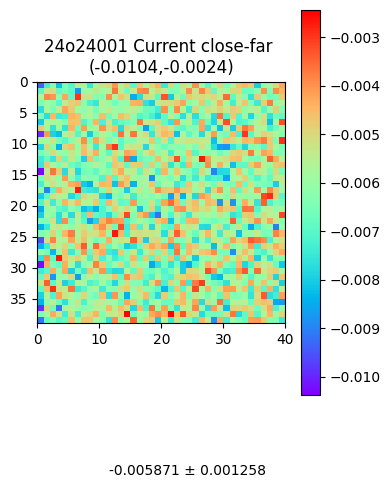

In [15]:
cur_difs = []
vmins = []
vmaxs = []
for i in range(len(abf_file)):
    target = I_closes[i]-I_fars[i]
    target = capture(target, first_row_repeat[i], ignore[i], extra[i], dim[i])
    mean = np.mean(target)
    std = np.std(target)
    print(f"%lf ± %lf" %(mean,std))
    cur_difs.append(target)
    vmins.append(target.min())
    vmaxs.append(target.max())
    
vmin = max(vmins)
vmax = min(vmaxs)
for i in range(len(abf_file)):
    figsize = (int(cur_difs[i].shape[0]/8), int(cur_difs[i].shape[1]/8))
    title = title_prefix[i] + " Current close-far"
    plot_colormap(cur_difs[i],title = title,path = fig_save_path, figsize = figsize,
                  vmin = vmin, vmax = vmax)

In [16]:
emf = []
cur = []
for i in range(len(abf_file)):
    emf.append(np.vstack((closes[i].flatten(),fars[i].flatten())))
    emf[i] = emf[i].reshape((emf[i].shape[1],emf[i].shape[0]))
    cur.append(np.vstack((I_closes[i].flatten(),I_fars[i].flatten())))
    cur[i] = cur[i].reshape((cur[i].shape[1],cur[i].shape[0]))

In [17]:
closes_2d = []
fars_2d = []
I_closes_2d = []
I_fars_2d = []
for i in range(len(abf_file)):
    closes_2d.append(capture(closes[i], first_row_repeat[i], ignore[i], extra[i], dim[i]))
    fars_2d.append(capture(fars[i], first_row_repeat[i], ignore[i], extra[i], dim[i]))
    I_closes_2d.append(capture(I_closes[i], first_row_repeat[i], ignore[i], extra[i], dim[i]))
    I_fars_2d.append(capture(I_fars[i], first_row_repeat[i], ignore[i], extra[i], dim[i]))

In [18]:
import pandas as pd
import csv
for i in range(len(abf_file)):
    targets = [emf_divs[i], emf_difs[i], closes_2d[i], fars_2d[i], cur_divs[i], cur_difs[i], I_closes[i], I_fars[i], emf[i], cur[i]]
    filenames = [" EMF close÷far"," EMF close-far", "EMF close", "EMF far",
                 " Current close÷far"," Current close-far", " Current close", " Current far", " EMF", " Current"]
    filenames = [title_prefix[i]+x+" " for x in filenames]
    for target, filename in zip(targets,filenames):
        write_target(target,filename)

# Test

## Test 01 -- With start time and end time

Close point found: 38
Far point found: 38


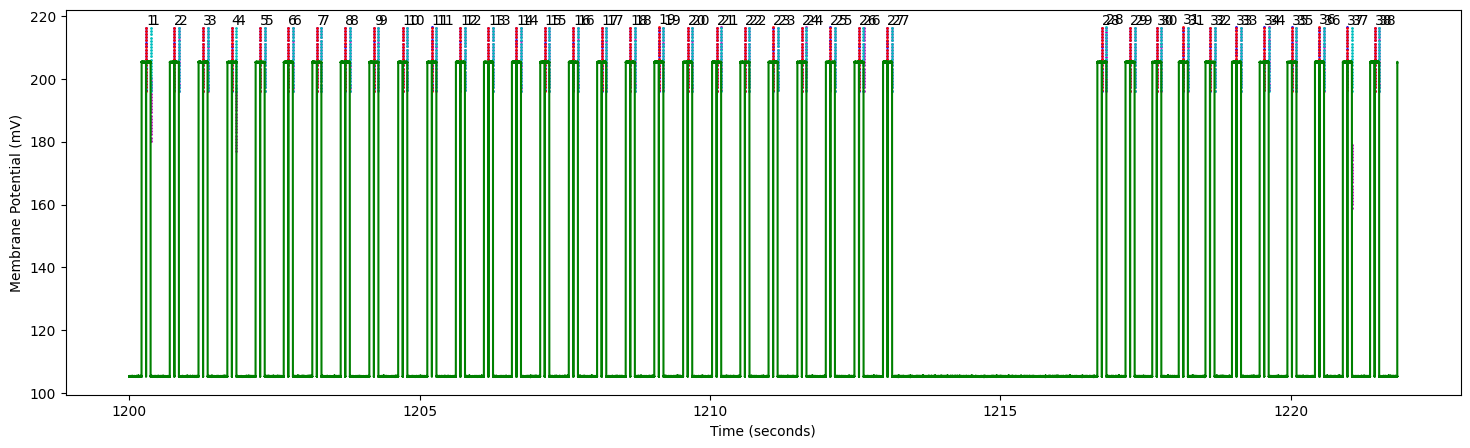

[]


In [19]:
timeStart = 30000000
timeEnd = 0
ind = 0
consider_single = False

if consider_single:
    s = single[ind]
else:
    s = (False,False)

plot_wave(abf[ind],volt[ind],single = s,timeStart = timeStart, timeEnd = None,channel=4)
print(abf[ind].sweepY[timeStart:timeEnd])

## Test 02_v2 -- Check all graph

Time: 0 ~ 200050
Close point found: 10
Far point found: 10


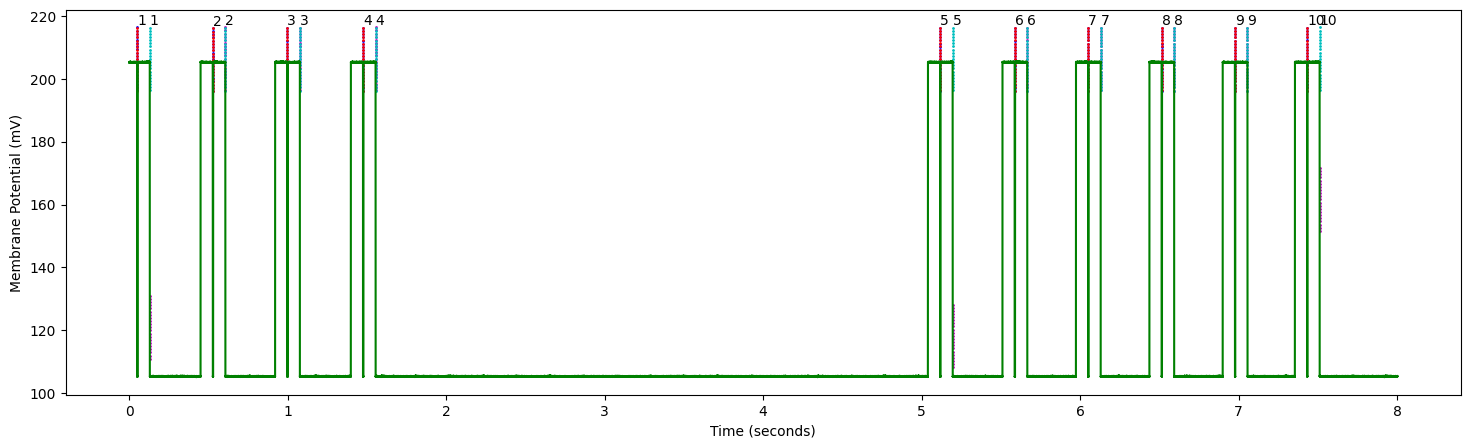

Time: 200000 ~ 400050
Close point found: 6
Far point found: 6


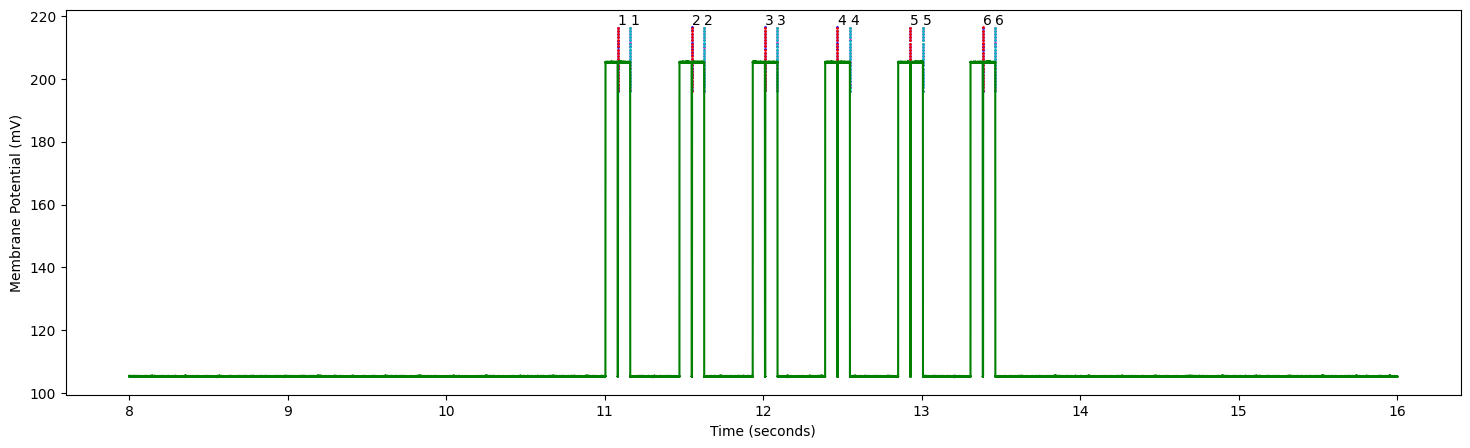

Time: 400000 ~ 600050
Close point found: 9
Far point found: 8


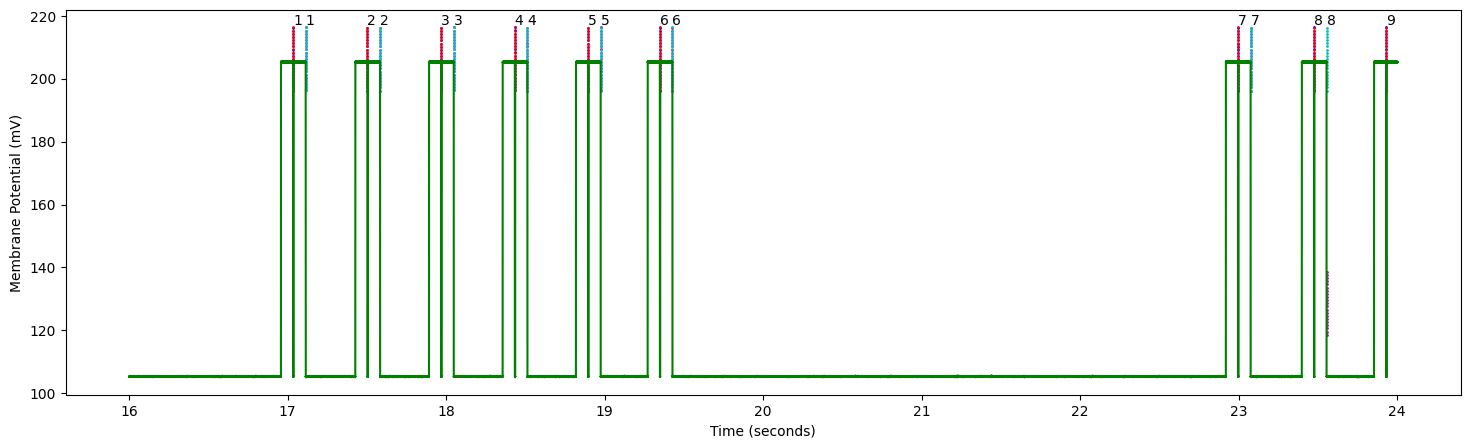

Time: 600000 ~ 800050
Close point found: 10
Far point found: 9


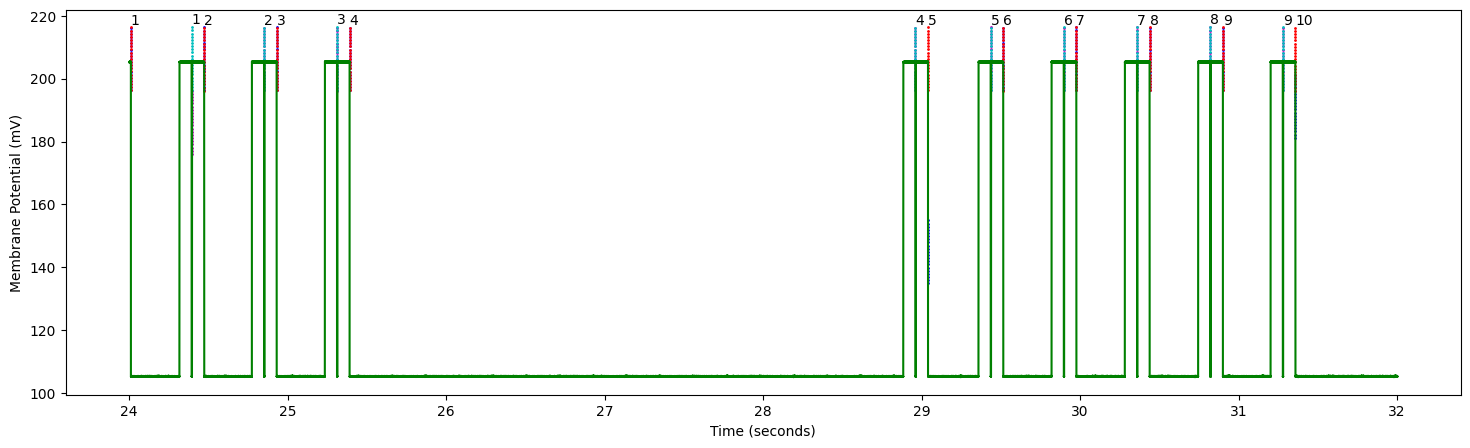

Time: 800000 ~ 1000050
Close point found: 6
Far point found: 6


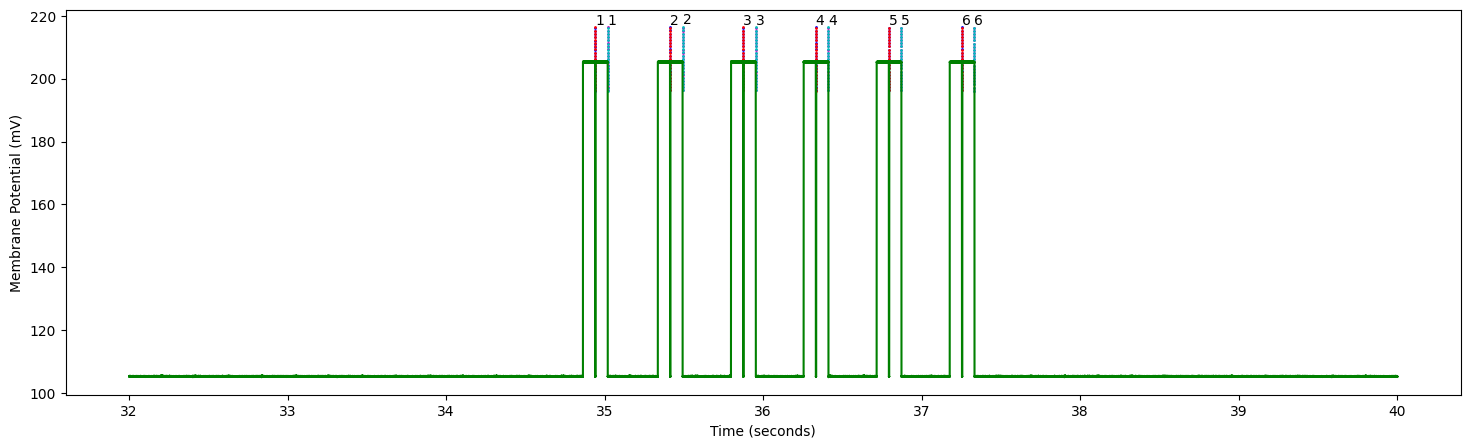

Time: 1000000 ~ 1200050
Close point found: 9
Far point found: 9


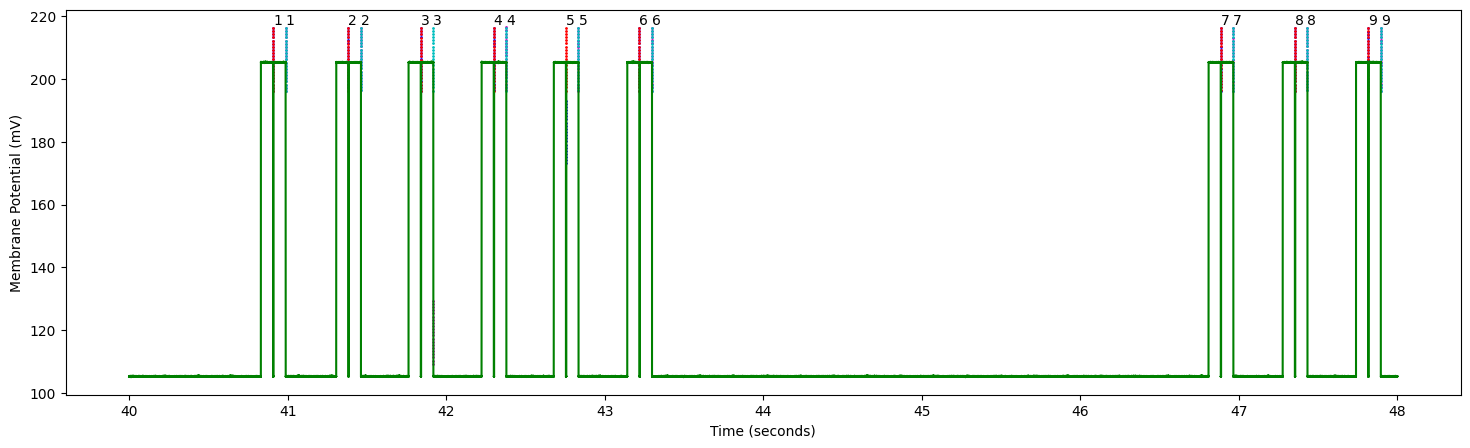

Time: 1200000 ~ 1400050
Close point found: 9
Far point found: 9


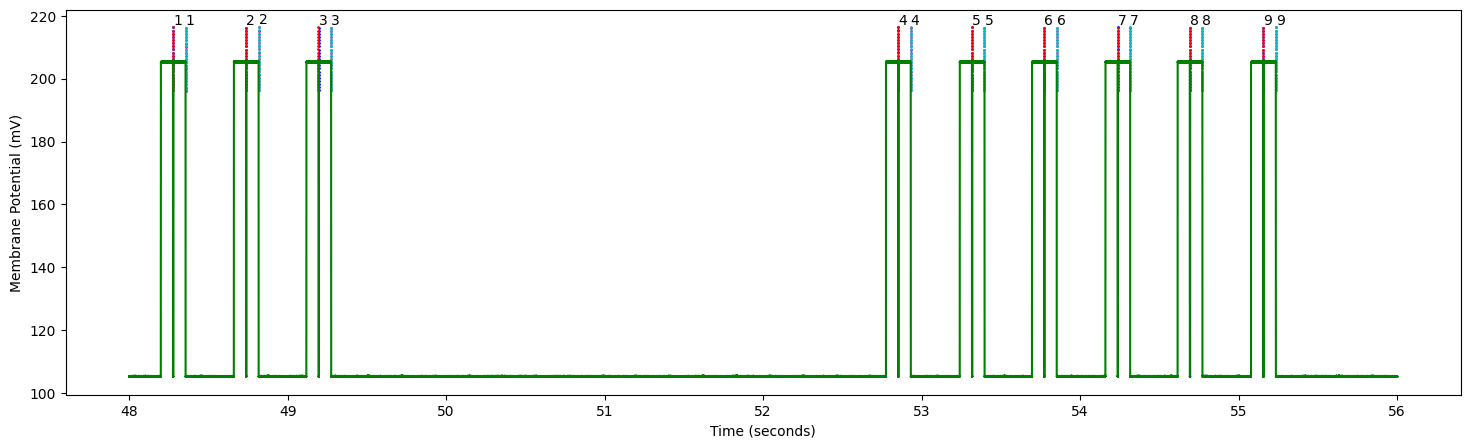

Time: 1400000 ~ 1600050
Close point found: 6
Far point found: 6


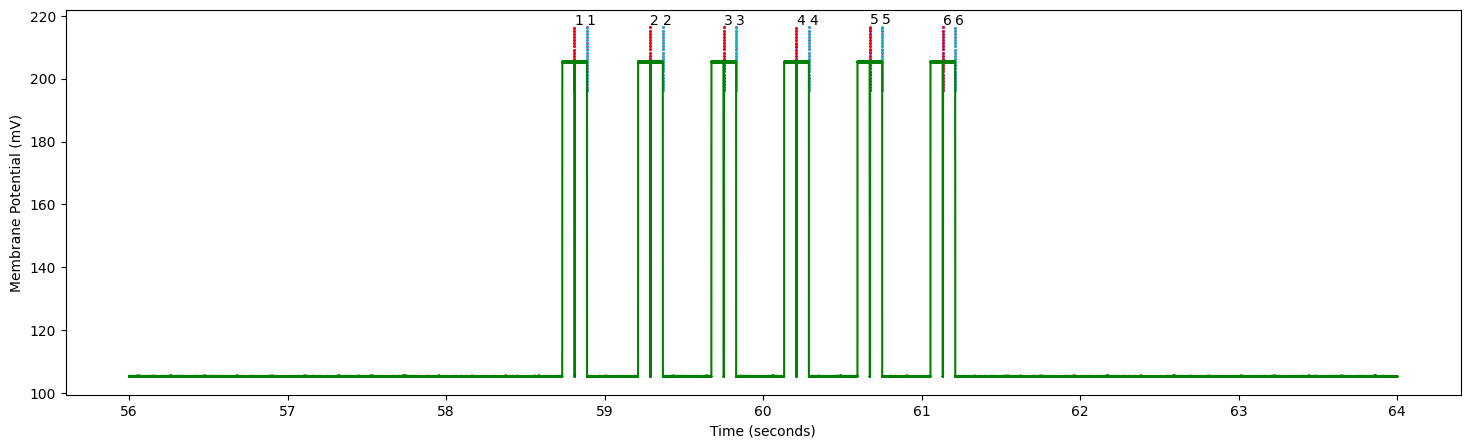

Time: 1600000 ~ 1800050
Close point found: 9
Far point found: 9


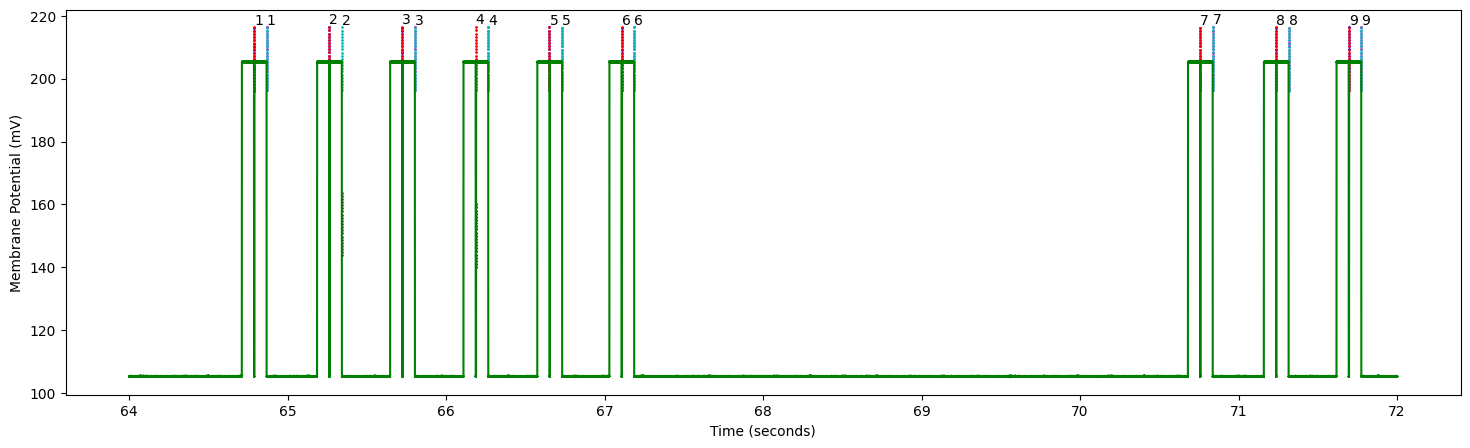

Time: 1800000 ~ 2000050
Close point found: 9
Far point found: 9


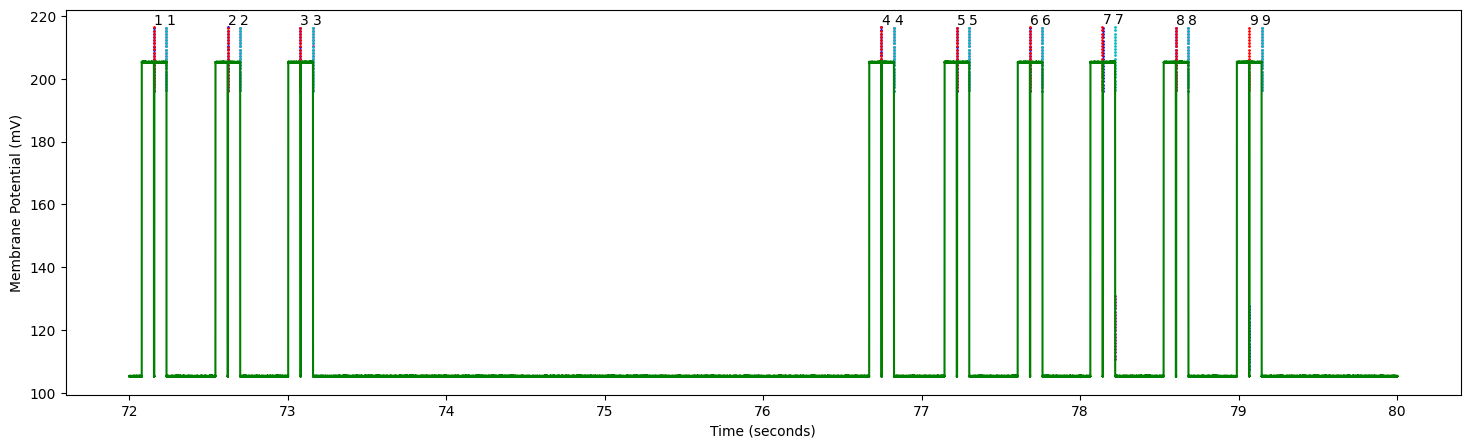

Time: 2000000 ~ 2200050
Close point found: 6
Far point found: 6


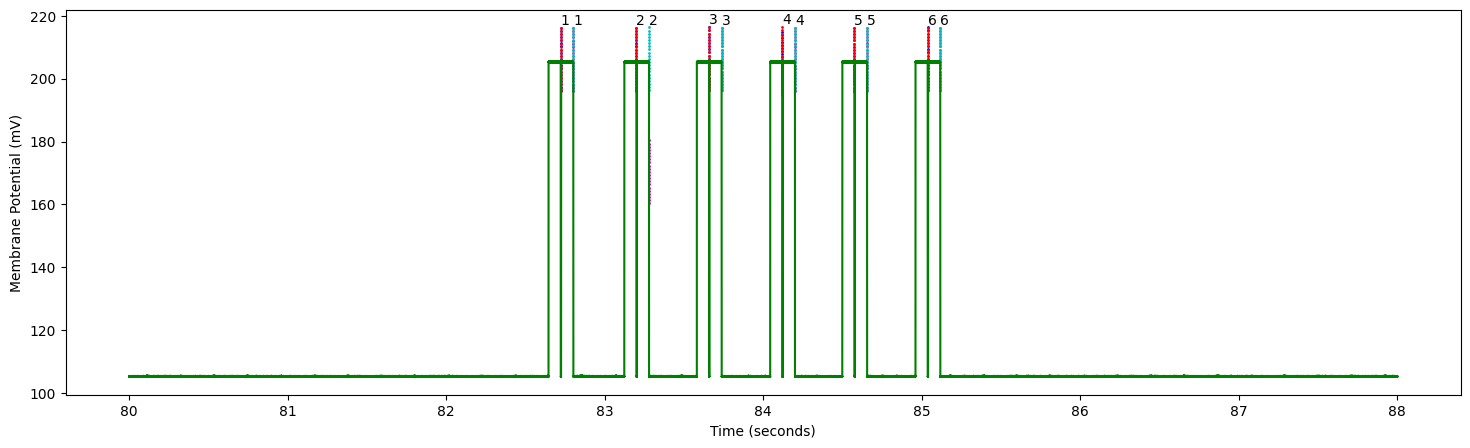

Time: 2200000 ~ 2400050
Close point found: 9
Far point found: 9


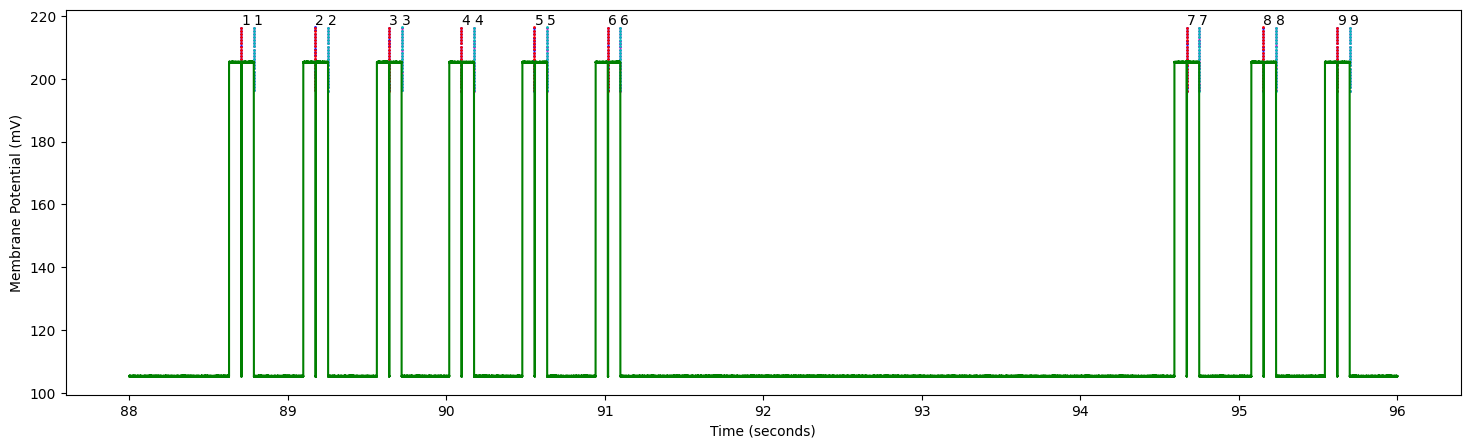

Time: 2400000 ~ 2600050
Close point found: 9
Far point found: 9


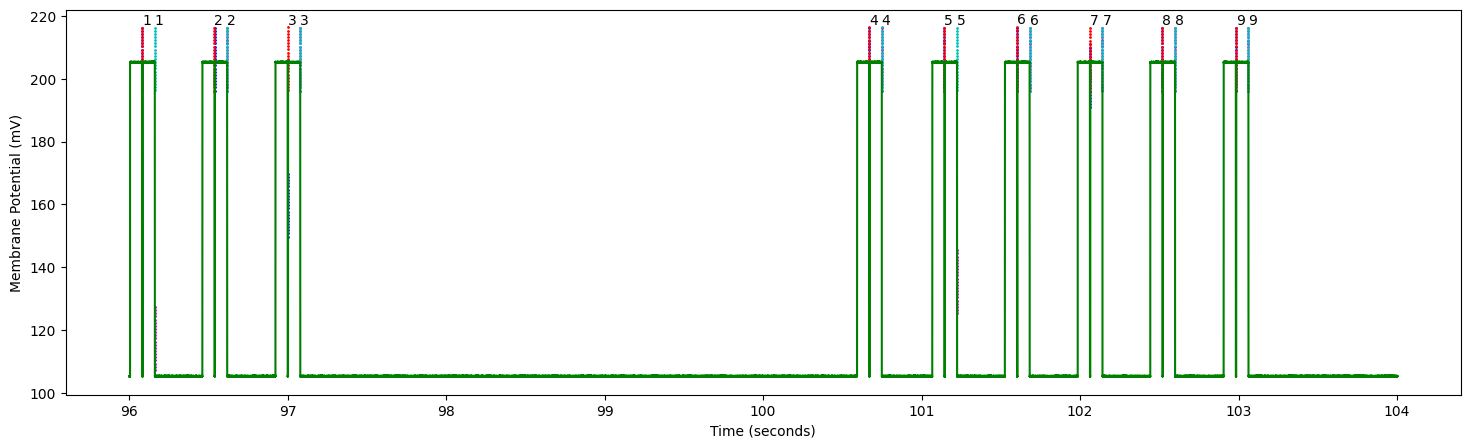

Time: 2600000 ~ 2800050
Close point found: 6
Far point found: 6


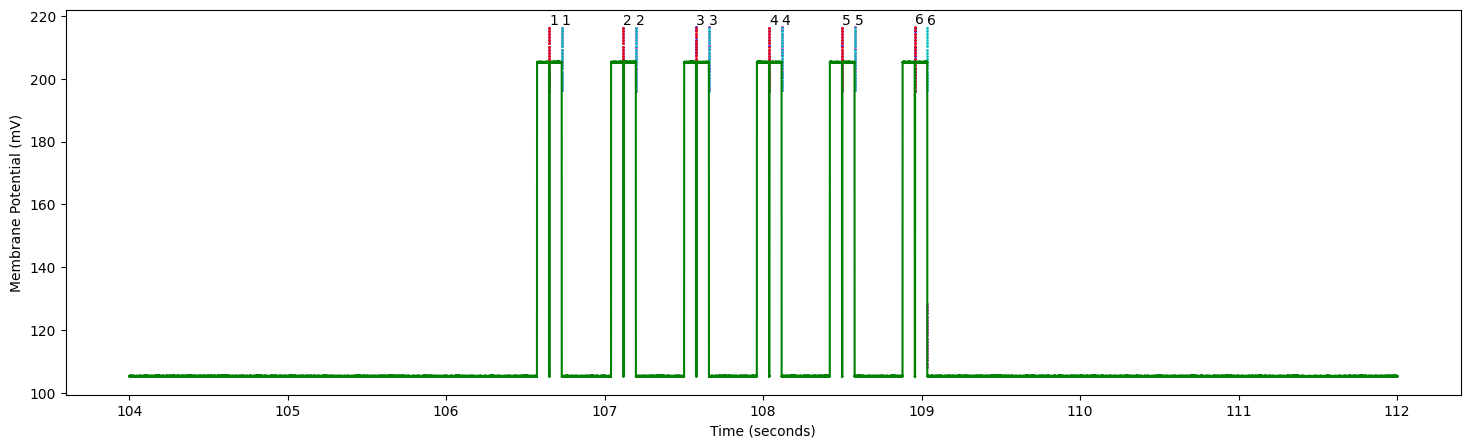

Time: 2800000 ~ 3000050
Close point found: 9
Far point found: 9


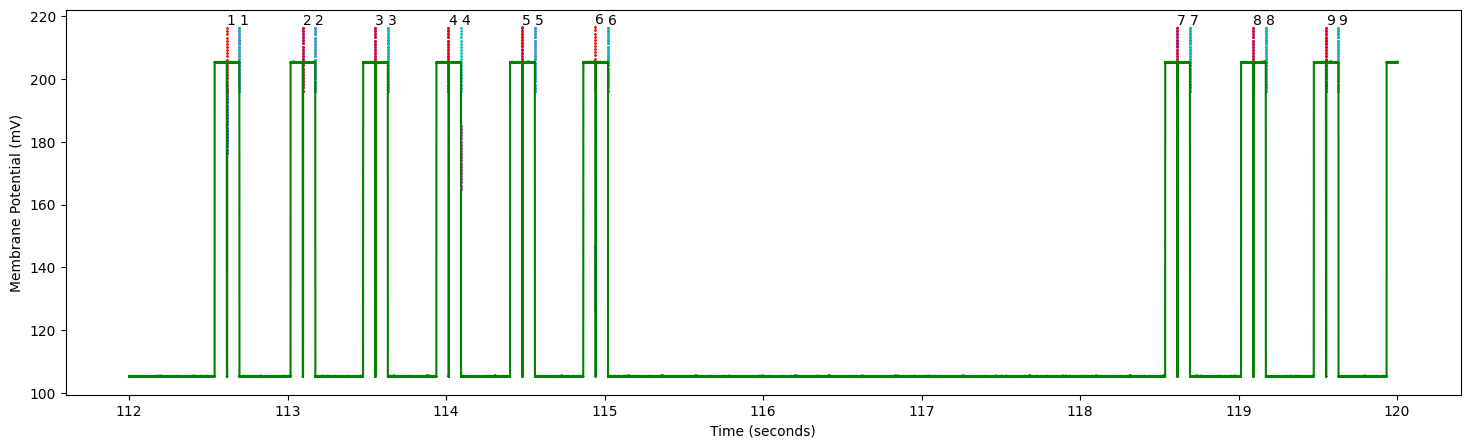

Time: 3000000 ~ 3200050
Close point found: 9
Far point found: 9


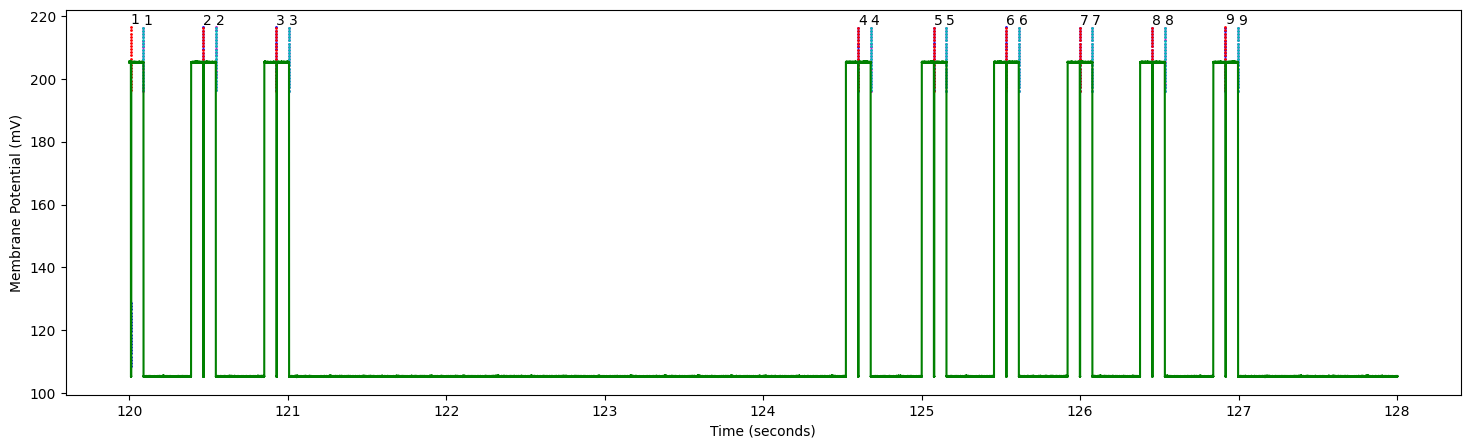

Time: 3200000 ~ 3400050
Close point found: 6
Far point found: 6


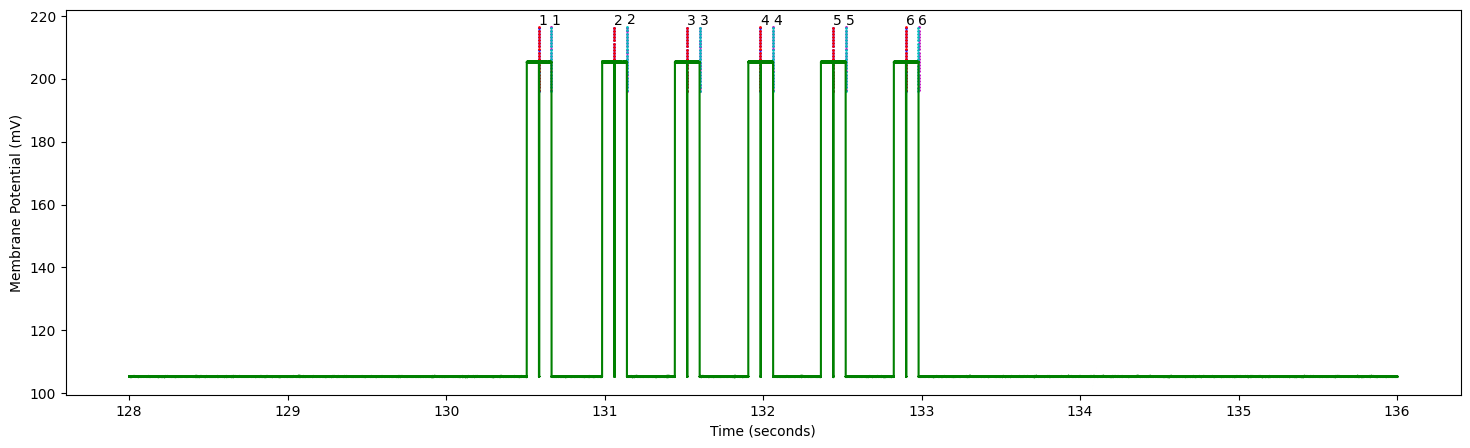

Time: 3400000 ~ 3600050
Close point found: 10
Far point found: 9


KeyboardInterrupt: 

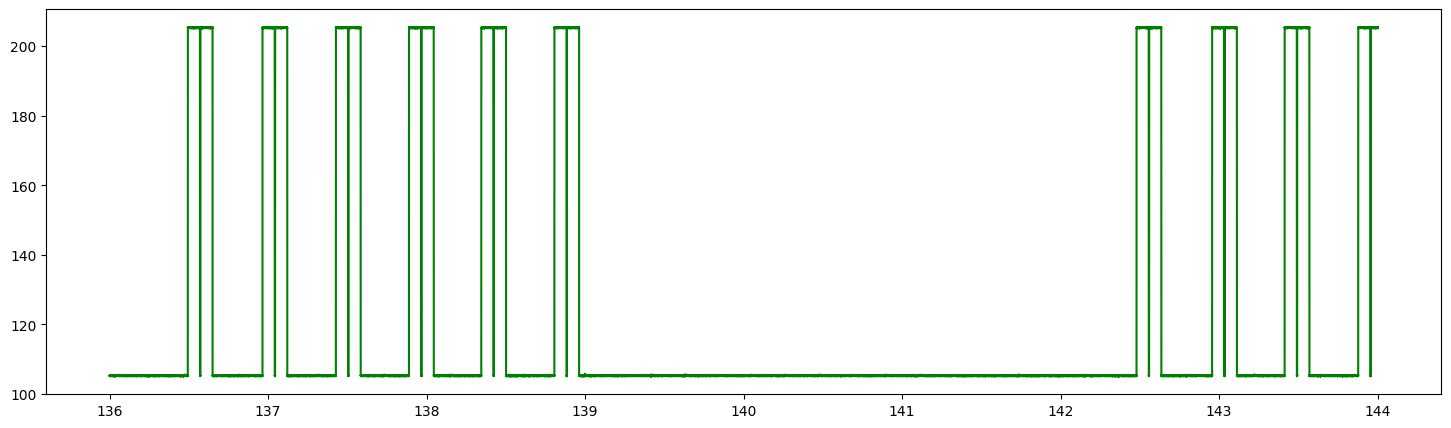

In [20]:
interval = 200000
ind = 0
consider_single = False

if consider_single:
    s = single[ind]
else:
    s = (False,False)
    
for i in range(0,len(abf[ind].sweepY),interval):
    print("Time: %d ~ %d"%(i,i+interval+50))
    timeStart = i
    timeEnd = i+interval+50
    close_qty,far_qty = plot_wave(abf[ind],volt[ind],single = s,timeStart = timeStart, timeEnd = timeEnd,channel = 4)

## Test 03_v3--Check Total Points Collected in each (x,y)

In [21]:
ind = 0

mat = print_points_qty(abf[ind],index = far_inds[ind])

  0. 16 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 Row Dimension:20 ; Row Total: 244
  1. 7  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  Row Dimension:20 ; Row Total: 45
  2. 7  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  Row Dimension:20 ; Row Total: 45
  3. 7  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  Row Dimension:20 ; Row Total: 45
  4. 7  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  Row Dimension:20 ; Row Total: 45
  5. 7  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  Row Dimension:20 ; Row Total: 45
  6. 7  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  Row Dimension:20 ; Row Total: 45
  7. 7  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  Row Dimension:20 ; Row Total: 45
  8. 7  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  Row Dimension:20 ; Row Total: 45
  9. 7  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  Row Dimension:20 ; Row Total: 45
 10. 7  2  2  2  2 

# Test 04: Check close far pairs

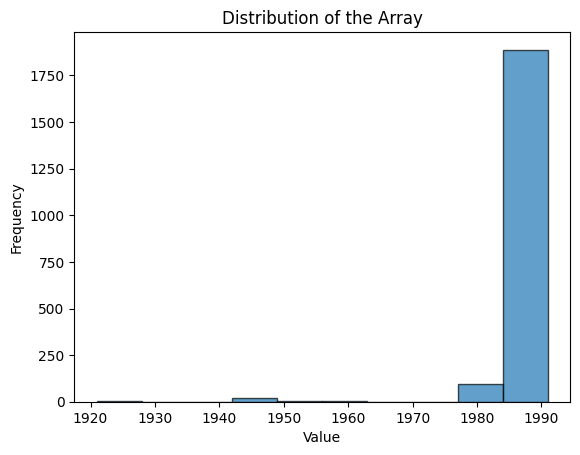

In [22]:
ind = 0
check_close_fair_pair(close_inds[ind],far_inds[ind], Row[ind], Col[ind], ignore[ind], extra[ind], first_row_repeat[ind], volt[ind], abf[ind])